In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import missingno as msno 

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, MinMaxScaler, StandardScaler, PolynomialFeatures

from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_validate

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split 
from sklearn import metrics

In [4]:
train = pd.read_csv('./data/train.csv', parse_dates=['datetime'])
test = pd.read_csv('./data/test.csv', parse_dates=['datetime'])
train.shape, test.shape

((10886, 12), (6493, 9))

In [5]:
train.sample(4)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
3212,2011-08-03 18:00:00,3,0,1,3,28.70,33.335,84,0.0000,49,443,492
4938,2011-11-18 20:00:00,4,0,1,1,11.48,13.635,48,12.9980,8,129,137
5853,2012-01-19 02:00:00,1,0,1,1,5.74,7.575,50,8.9981,0,3,3
3417,2011-08-12 07:00:00,3,0,1,1,26.24,31.060,44,11.0014,17,247,264


In [6]:
cor_matrix = train.corr()
cor_matrix['count'].sort_values(ascending=False)

count         1.000000
registered    0.970948
casual        0.690414
temp          0.394454
atemp         0.389784
season        0.163439
windspeed     0.101369
workingday    0.011594
holiday      -0.005393
weather      -0.128655
humidity     -0.317371
Name: count, dtype: float64

In [7]:
train['datetime']

0       2011-01-01 00:00:00
1       2011-01-01 01:00:00
2       2011-01-01 02:00:00
3       2011-01-01 03:00:00
4       2011-01-01 04:00:00
                ...        
10881   2012-12-19 19:00:00
10882   2012-12-19 20:00:00
10883   2012-12-19 21:00:00
10884   2012-12-19 22:00:00
10885   2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: datetime64[ns]

In [8]:
train1 = train.set_index('datetime', inplace=False)

## Data Fields

- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

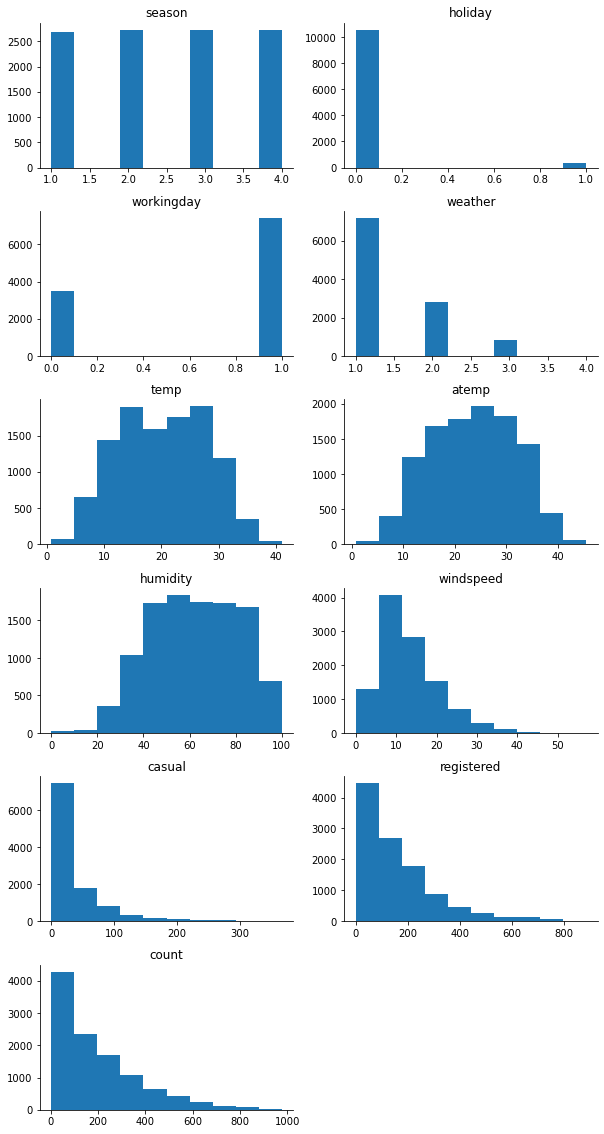

In [9]:

fig, axes = plt.subplots(6, 2, figsize = (10, 20))
plt.subplots_adjust(hspace = .3)
x, y = 0, 0 

for col in train1.columns:
    axes[x, y].hist(train1[col])
    axes[x, y].set_title(col)
    axes[x, y].spines['top'].set_visible(False)
    axes[x, y].spines['right'].set_visible(False)
    y +=1
    if y == 2:
        y = 0 
        x +=1
        
axes[x, y].spines['top'].set_visible(False)
axes[x, y].spines['right'].set_visible(False)
axes[x, y].spines['left'].set_visible(False)
axes[x, y].spines['bottom'].set_visible(False) 
axes[x, y].tick_params(axis = 'both', which = 'both', bottom = False, left = False,
                      labelbottom = False, labelleft = False)

In [10]:
train.index

RangeIndex(start=0, stop=10886, step=1)

In [11]:
def date_transform(x):
    x['hour']=x['datetime'].dt.hour
    x['month']=x['datetime'].dt.month
    x['day']=x['datetime'].dt.weekday
    return x


In [12]:
train = date_transform(train)

In [13]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'hour', 'month', 'day'],
      dtype='object')

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  hour        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  day         10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(11)
memory usage: 1.2 MB


<AxesSubplot:>

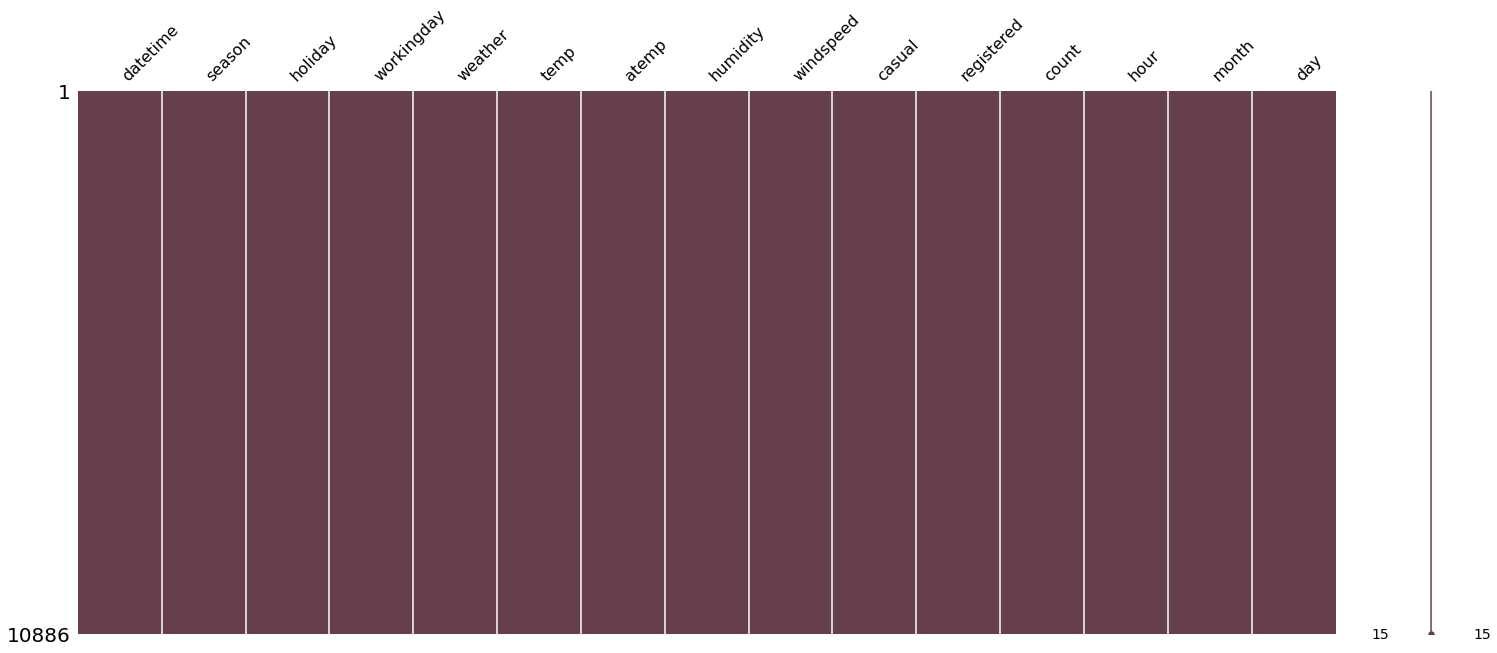

In [15]:
msno.matrix(train, color=(0.40, 0.25, 0.30)) #to check if there is some missing value.


In [32]:
cols = ['season','temp', 'day', 'humidity', 'hour', 'weather', 'holiday'  ]
train[cols]

,season,temp,day,humidity,hour,weather,holiday
0,1,9.84,5,81,0,1,0
1,1,9.02,5,80,1,1,0
2,1,9.02,5,80,2,1,0
3,1,9.84,5,75,3,1,0
4,1,9.84,5,75,4,1,0
...,...,...,...,...,...,...,...
10881,4,15.58,2,50,19,1,0
10882,4,14.76,2,57,20,1,0
10883,4,13.94,2,61,21,1,0
10884,4,13.94,2,61,22,1,0


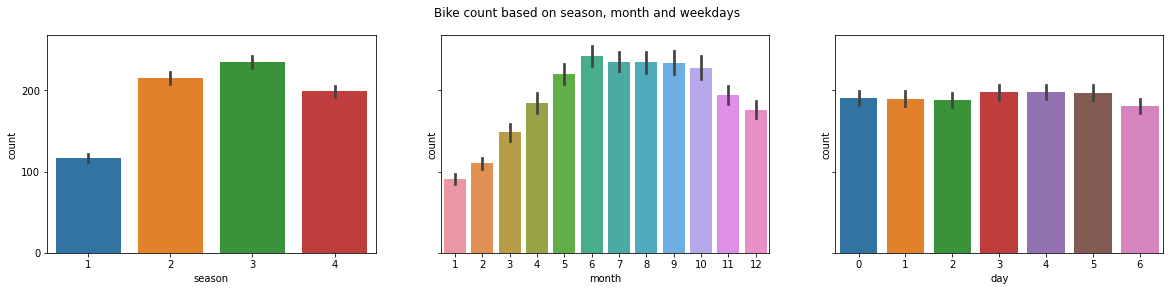

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(20, 4), sharey=True)
fig.suptitle('Bike count based on season, month and weekdays')

sns.barplot(ax=axes[0], x=train['season'], y=train['count'])
axes[0].set_title('')

sns.barplot(ax=axes[1], x=train['month'], y=train['count'])
axes[1].set_title('')

sns.barplot(ax=axes[2], x=train['day'], y=train['count'])
axes[2].set_title('')
plt.rcParams.update({'font.size': 22})


Text(0.5, 1.0, '')

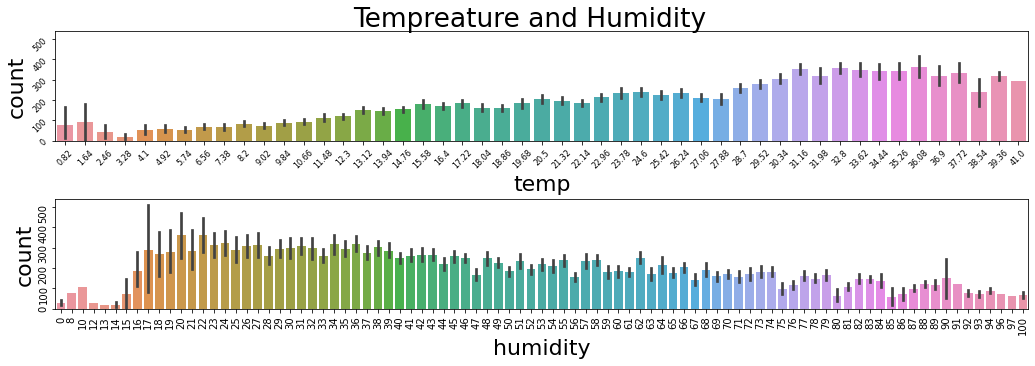

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(15, 5), sharey=True)

fig.tight_layout()

fig.suptitle('Tempreature and Humidity')

sns.barplot(ax=axes[0], x=train['temp'], y=train['count']).tick_params(labelsize = 8, rotation = 45)
axes[0].set_title('')

sns.barplot(ax=axes[1], x=train['humidity'], y=train['count']).tick_params(labelsize = 10, rotation = 90)
axes[1].set_title('')

In [35]:
y = train['count']

cols = ['season','temp', 'day', 'humidity', 'hour', 'weather', 'holiday'  ]
X = train[cols]


In [36]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)

In [37]:
Xtrain.shape, Xtest.shape

((7620, 7), (3266, 7))

In [38]:
ytrain.shape, ytest.shape

((7620,), (3266,))

# pipeline

In [39]:
scaling_and_polynomial = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=2, include_bias=False)
)

In [40]:
fe = ColumnTransformer([
    
    ('scaling', MinMaxScaler(), ['temp']),
     ('binning', KBinsDiscretizer(), ['holiday']),
    ('one-hot-encode', OneHotEncoder(sparse=False, handle_unknown='ignore'), ['season', 'hour', 'day', 'weather']),
    ('scaling_and_polynomial', scaling_and_polynomial, ['humidity', 'temp'])  
])



In [56]:
model = make_pipeline(
    fe,

    RandomForestRegressor()
)

In [57]:
model.fit(Xtrain, ytrain)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('scaling',
                                                  MinMaxScaler(copy=True,
                                                               feature_range=(0,
                                                                              1)),
                                                  ['temp']),
                                                 ('binning',
                                                  KBinsDiscretizer(encode='onehot',
                                                                   n_bins=5,
                                                                   strategy='quantile'),
                                                  ['holiday']),
                     

In [58]:

# calculate the cv-test and cv-train performance using the mean squared error

cv = cross_validate(
    estimator = model,                       # the model 
    X = X,                              # input data 
    y = y,                               # target data
    cv = 5,                             # number of datasets in cross validation
    scoring = 'neg_mean_squared_error',   # evaluation metric (MSE)
    return_train_score = True             # return both cv-training and cv-test scores
)

# convert the cv into a dataframe and caluclate the average cv scores

cv_result = pd.DataFrame(cv)
cv_result


# fit the model on the data

model.fit(X, y)

# calculate predictions

y_pred= model.predict(X)
# plot the predicted regression line together with the scatterplot of the data



/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the number of bins.' % jj)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_discretization.py:193: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  'decreasing the

In [59]:
y_pred = model.predict(Xtrain)
y_pred.shape , ytrain.shape

((7620,), (7620,))

In [60]:
# convert all negative values to 0
y_pred[y_pred < 0] = 0
# ytrain[ytrain<0] = 0

mean_squared_log_error(ytrain, y_pred)**0.5

0.27888809501064943

In [61]:
test = date_transform(test)

In [62]:
test.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'hour', 'month', 'day'],
      dtype='object')

In [63]:


test



,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,month,day
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,0,1,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,1,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2,1,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,3,1,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,4,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,19,12,0
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,20,12,0
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,21,12,0
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,22,12,0


In [64]:
y_pred_kaggel = model.predict(test)
y_pred_kaggel

array([22.4,  9.1,  7.2, ..., 74.4, 94.8, 32.6])

In [65]:

y_pred_kaggel[y_pred_kaggel < 0] = 0
ytest[ytest<0] = 0

mean_squared_log_error(ytrain, y_pred)**0.5

0.27888809501064943

In [66]:
submission = pd.DataFrame(y_pred_kaggel, index=test['datetime'], columns = ['count'])


submission.to_csv('./data/submission2.csv', index=True)

submission

,count
datetime,
2011-01-20 00:00:00,22.40
2011-01-20 01:00:00,9.10
2011-01-20 02:00:00,7.20
2011-01-20 03:00:00,7.60
2011-01-20 04:00:00,2.00
...,...
2012-12-31 19:00:00,157.90
2012-12-31 20:00:00,80.45
2012-12-31 21:00:00,74.40
